### 原代码

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
#包的准备

In [3]:
class stock_info:
    def __init__(self, filepath, target_col):
        # Load data from HDF file
        self.raw = pd.read_hdf(filepath)
        
        # Extract the target column i.e "IC"
        self.target_raw = self.raw[target_col]
        
        # Get the list of dates
        self.dates = self.target_raw.index.tolist()
        
        # initiate a new dataframe recording daily return 
        self.readouts = pd.DataFrame(self.dates, columns=["dates"])
        self.readouts.set_index("dates", inplace=True)
        
        # Calculate T_last_close and T_vap (VWAP)
        self.readouts["T_last_close"] = [
            self.target_raw.loc[date]["Close"].iloc[-1] for date in self.dates
        ]
        self.readouts["T_vap"] = [
            (self.target_raw.loc[date]["Close"] * self.target_raw.loc[date]["Volume"]).sum() /
            self.target_raw.loc[date]["Volume"].sum()
            for date in self.dates
        ]
        
        # Calculate default strategy
        # if the last close price is higher than VWAP (T_vap), sell (-1), otherwise buy (+1)
        ratio = np.array(self.readouts["T_last_close"]) / np.array(self.readouts["T_vap"])
        self.readouts["default_st"] = np.where(ratio > 1., -1, 1)

    def evaluate_return_T_p1(self, t_exec, strategy_array_name="default_st"):
        # read strategy for T+1
        strategy_ = np.array(self.readouts[strategy_array_name].tolist()[:-2])
        
        # read close price at specified time in T+1 and T+2 respectively
        short_price_T_p1 = np.array([self.target_raw.loc[day]["Close"].iloc[t_exec] for day in self.dates[1:-1]])
        long_price_T_p2 = np.array([self.target_raw.loc[day]["Close"].iloc[t_exec] for day in self.dates[2:]])
        
        # calculate return rate at T+1
        return_rate_T_p1 = pd.Series(((long_price_T_p2/short_price_T_p1)-1.)*strategy_, index=self.dates[:-2])
        
        # append to self.readouts
        self.readouts["return_"+strategy_array_name+"_"+str(t_exec)] = return_rate_T_p1

    def get_sharpe_ratio(self, strategy_return):
        # obtain return rate under specified strategy
        return_arr = self.readouts[strategy_return].tolist()[:-2]
        
        # calculate traditional sharpe ratio
        sharpe_ratio = np.sqrt(250.)*np.mean(return_arr)/np.std(return_arr)
        return sharpe_ratio

    def generate_time_dependency(self, strategy_array_name):
        fig, ax1 = plt.subplots(1, 1)
        
        # array of trading time
        fibonnacci = [0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 239]
        return_arr = []
        
        for t_exec in fibonnacci:
            # calculate return rate of combinations of strategy with different trading times
            self.evaluate_return_T_p1(t_exec, strategy_array_name=strategy_array_name)
            # record sharpe ratio
            return_arr.append(self.get_sharpe_ratio(strategy_return="return_"+strategy_array_name+"_"+str(t_exec)))
            
        # plot sensitivity    
        ax1.plot(fibonnacci, return_arr, label="sharpe ratio", c="blue")
        ax1.scatter(fibonnacci, return_arr, c="blue")
        title = "time sensitivity of " + strategy_array_name
        ax1.set_title(title)
        ax1.set_xlabel("trading time (min)")
        ax1.set_ylabel("sharpe ratio")
        plt.legend()
        plt.show()


            T_last_close        T_vap  default_st  improved_st  \
dates                                                            
2010-01-04     4510.5300  4517.872190           1            1   
2010-01-05     4557.4700  4523.397009          -1           -1   
2010-01-06     4550.2800  4571.448964           1            1   
2010-01-07     4459.1600  4504.975384           1            1   
2010-01-08     4514.4500  4464.550621          -1           -1   
...                  ...          ...         ...          ...   
2024-06-24     4992.9097  5031.758276           1            1   
2024-06-25     4948.6343  4970.941322           1            1   
2024-06-26     5020.4318  4959.906108          -1           -1   
2024-06-27     4928.0514  4957.052406           1            1   
2024-06-28     4942.7817  4969.488927           1            1   

            return_default_st_59  
dates                             
2010-01-04              0.015778  
2010-01-05              0.012997  
2

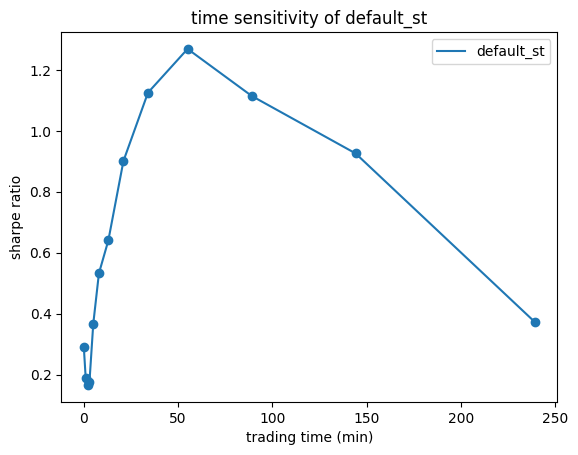

In [5]:
mydata = stock_info("MinutesIdx.h5", "IC")

mydata.evaluate_return_T_p1(59)
print(mydata.readouts)
mydata.generate_time_dependency("default_st")

### 固定阈值

Exception ignored in: <generator object Cycler.__iter__ at 0x156e8bd30>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/data_env/lib/python3.11/site-packages/cycler.py", line 242, in __iter__
    yield dict(left)
  File "_pydevd_bundle\\pydevd_cython.pyx", line 1697, in _pydevd_bundle.pydevd_cython.SafeCallWrapper.__call__
  File "_pydevd_bundle\\pydevd_cython.pyx", line 2017, in _pydevd_bundle.pydevd_cython.ThreadTracer.__call__
  File "/opt/anaconda3/envs/data_env/lib/python3.11/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_is_thread_alive.py", line 20, in is_thread_alive
    def is_thread_alive(t):

KeyboardInterrupt: 


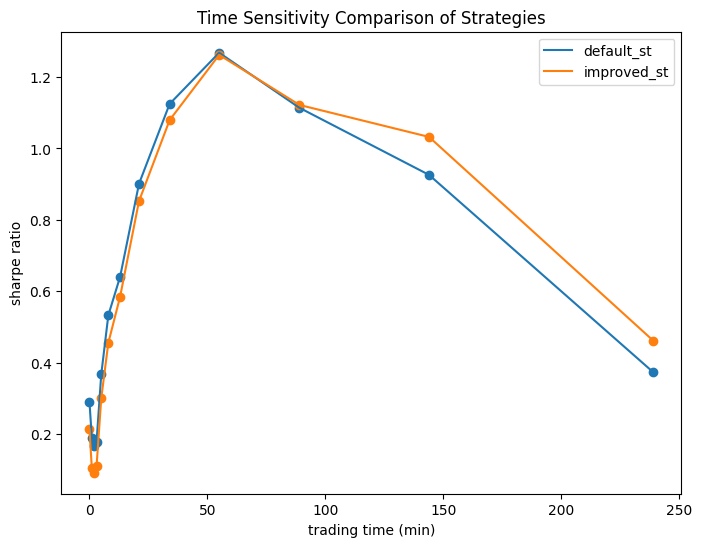

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

# 定义类
class stock_info:
    def __init__(self, filepath, target_col):
        # 读取HDF文件
        self.raw = pd.read_hdf(filepath)
        # 提取某一个目标列(如“IC”)
        self.target_raw = self.raw[target_col]
        # 拿到所有的交易日列表
        self.dates = self.target_raw.index.tolist()
        # 初始化一个DataFrame,用于记录结果
        self.readouts = pd.DataFrame(self.dates, columns=["dates"])
        self.readouts.set_index("dates", inplace=True)

        # 计算T日收盘价和VWAP(成交量加权平均价)
        self.readouts["T_last_close"] = [
            self.target_raw.loc[date]["Close"].iloc[-1] for date in self.dates
        ]
        self.readouts["T_vap"] = [
            (self.target_raw.loc[date]["Close"] * self.target_raw.loc[date]["Volume"]).sum()
            / self.target_raw.loc[date]["Volume"].sum()
            for date in self.dates
        ]

        # ========= 策略1：原始反转策略 =========
        ratio = np.array(self.readouts["T_last_close"]) / np.array(self.readouts["T_vap"])
        self.readouts["default_st"] = np.where(ratio > 1., -1, 1)

        # ========= 策略2：固定阈值 =========
        deviation = (self.readouts["T_last_close"] - self.readouts["T_vap"]) / self.readouts["T_vap"]
        threshold = 0.001  # 固定阈值 0.1%
        self.readouts["improved_st"] = np.where(
            deviation > threshold, -1,
            np.where(deviation < -threshold, 1, 0)
        )

    # 计算策略收益
    def evaluate_return_T_p1(self, t_exec, strategy_array_name="default_st"):
        strategy_ = np.array(self.readouts[strategy_array_name].tolist()[:-2])
        short_price_T_p1 = np.array([self.target_raw.loc[day]["Close"].iloc[t_exec] for day in self.dates[1:-1]])
        long_price_T_p2 = np.array([self.target_raw.loc[day]["Close"].iloc[t_exec] for day in self.dates[2:]])
        return_rate_T_p1 = pd.Series(((long_price_T_p2 / short_price_T_p1) - 1.) * strategy_,
                                     index=self.dates[:-2])
        self.readouts["return_" + strategy_array_name + "_" + str(t_exec)] = return_rate_T_p1

    # 计算夏普比率
    def get_sharpe_ratio(self, strategy_return):
        return_arr = self.readouts[strategy_return].tolist()[:-2]
        if np.std(return_arr) == 0:
            return 0
        sharpe_ratio = np.sqrt(250.) * np.mean(return_arr) / np.std(return_arr)
        return sharpe_ratio

    # 单策略敏感性分析
    def generate_time_dependency(self, strategy_array_name):
        fig, ax1 = plt.subplots(1, 1)
        fibonnacci = [0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 239]
        return_arr = []
        for t_exec in fibonnacci:
            self.evaluate_return_T_p1(t_exec, strategy_array_name=strategy_array_name)
            return_arr.append(
                self.get_sharpe_ratio("return_" + strategy_array_name + "_" + str(t_exec))
            )
        ax1.plot(fibonnacci, return_arr, label=strategy_array_name)
        ax1.scatter(fibonnacci, return_arr)
        title = "time sensitivity of " + strategy_array_name
        ax1.set_title(title)
        ax1.set_xlabel("trading time (min)")
        ax1.set_ylabel("sharpe ratio")
        plt.legend()
        plt.show()

    # 多策略敏感性对比
    def generate_multi_time_dependency(self, strategy_list):
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        fibonnacci = [0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 239]

        for strategy_array_name in strategy_list:
            return_arr = []
            for t_exec in fibonnacci:
                self.evaluate_return_T_p1(t_exec, strategy_array_name=strategy_array_name)
                return_arr.append(
                    self.get_sharpe_ratio("return_" + strategy_array_name + "_" + str(t_exec))
                )
            ax.plot(fibonnacci, return_arr, label=strategy_array_name)
            ax.scatter(fibonnacci, return_arr)

        ax.set_title("Time Sensitivity Comparison of Strategies")
        ax.set_xlabel("trading time (min)")
        ax.set_ylabel("sharpe ratio")
        plt.legend()
        plt.show()


# ===== 使用示例 =====
mydata = stock_info("MinutesIdx.h5", "IC")

# 只展示 策略1 和 策略2 的对比曲线
mydata.generate_multi_time_dependency(
    ["default_st", "improved_st"]
)


### 固定阈值 ➕ 自适应阈值 ➕ 自适应阈值、趋势过滤

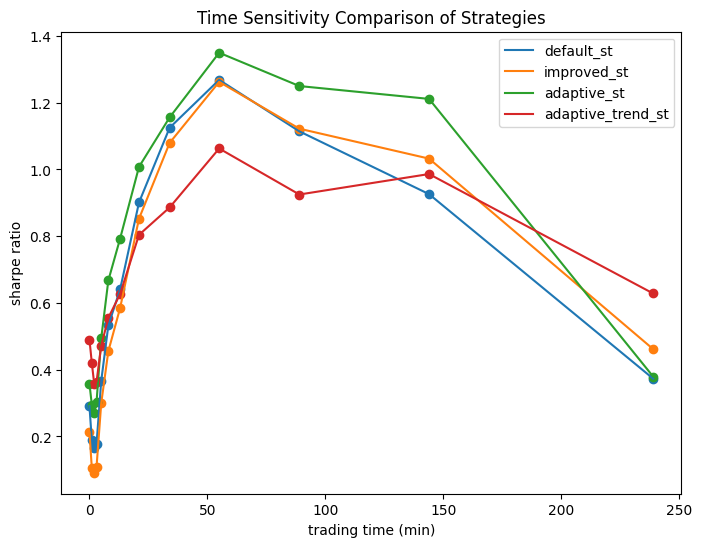

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

# 定义类
class stock_info:
    def __init__(self, filepath, target_col):
        # 读取HDF文件
        self.raw = pd.read_hdf(filepath)
        # 提取某一个目标列(如“IC”)
        self.target_raw = self.raw[target_col]
        # 拿到所有的交易日列表
        self.dates = self.target_raw.index.tolist()
        # 初始化一个DataFrame,用于记录结果
        self.readouts = pd.DataFrame(self.dates, columns=["dates"])
        self.readouts.set_index("dates", inplace=True)

        # 计算T日收盘价和VWAP(成交量加权平均价)
        self.readouts["T_last_close"] = [
            self.target_raw.loc[date]["Close"].iloc[-1] for date in self.dates
        ]
        self.readouts["T_vap"] = [
            (self.target_raw.loc[date]["Close"] * self.target_raw.loc[date]["Volume"]).sum()
            / self.target_raw.loc[date]["Volume"].sum()
            for date in self.dates
        ]

        # ========= 策略1：原始反转策略 =========
        ratio = np.array(self.readouts["T_last_close"]) / np.array(self.readouts["T_vap"])
        self.readouts["default_st"] = np.where(ratio > 1., -1, 1)

        # ========= 策略2：固定阈值 =========
        deviation = (self.readouts["T_last_close"] - self.readouts["T_vap"]) / self.readouts["T_vap"]
        threshold = 0.001  # 固定阈值 0.05%
        self.readouts["improved_st"] = np.where(
            deviation > threshold, -1,
            np.where(deviation < -threshold, 1, 0)
        )

        # ========= 策略3：自适应阈值 =========
        window = 7  # 最近7天波动
        rolling_std = deviation.rolling(window=window, min_periods=5).std().fillna(method="bfill")
        self.readouts["adaptive_st"] = np.where(
            deviation > rolling_std, -1,
            np.where(deviation < -rolling_std, 1, 0)
        )

        # ========= 策略4：自适应阈值 + 趋势过滤 =========
        window_ma = 54  # 均线长度
        ma = self.readouts["T_last_close"].rolling(window=window_ma, min_periods=5).mean().fillna(method="bfill")

        adaptive = self.readouts["adaptive_st"].copy()

        def trend_filter(sig, close, ma_val):
            if sig == 0:
                return 0
            elif close > ma_val and sig == 1:   # 均线上只做多
                return 1
            elif close < ma_val and sig == -1:  # 均线下只做空
                return -1
            else:
                return 0  # 反趋势信号过滤掉

        self.readouts["adaptive_trend_st"] = [
            trend_filter(sig, close, ma_val)
            for sig, close, ma_val in zip(adaptive, self.readouts["T_last_close"], ma)
        ]

    # 计算策略收益
    def evaluate_return_T_p1(self, t_exec, strategy_array_name="default_st"):
        strategy_ = np.array(self.readouts[strategy_array_name].tolist()[:-2])
        short_price_T_p1 = np.array([self.target_raw.loc[day]["Close"].iloc[t_exec] for day in self.dates[1:-1]])
        long_price_T_p2 = np.array([self.target_raw.loc[day]["Close"].iloc[t_exec] for day in self.dates[2:]])
        return_rate_T_p1 = pd.Series(((long_price_T_p2 / short_price_T_p1) - 1.) * strategy_,
                                     index=self.dates[:-2])
        self.readouts["return_" + strategy_array_name + "_" + str(t_exec)] = return_rate_T_p1

    # 计算夏普比率
    def get_sharpe_ratio(self, strategy_return):
        return_arr = self.readouts[strategy_return].tolist()[:-2]
        if np.std(return_arr) == 0:
            return 0
        sharpe_ratio = np.sqrt(250.) * np.mean(return_arr) / np.std(return_arr)
        return sharpe_ratio

    # 单策略敏感性分析
    def generate_time_dependency(self, strategy_array_name):
        fig, ax1 = plt.subplots(1, 1)
        fibonnacci = [0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 239]
        return_arr = []
        for t_exec in fibonnacci:
            self.evaluate_return_T_p1(t_exec, strategy_array_name=strategy_array_name)
            return_arr.append(
                self.get_sharpe_ratio("return_" + strategy_array_name + "_" + str(t_exec))
            )
        ax1.plot(fibonnacci, return_arr, label=strategy_array_name)
        ax1.scatter(fibonnacci, return_arr)
        title = "time sensitivity of " + strategy_array_name
        ax1.set_title(title)
        ax1.set_xlabel("trading time (min)")
        ax1.set_ylabel("sharpe ratio")
        plt.legend()
        plt.show()

    # 多策略敏感性对比
    def generate_multi_time_dependency(self, strategy_list):
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        fibonnacci = [0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 239]

        for strategy_array_name in strategy_list:
            return_arr = []
            for t_exec in fibonnacci:
                self.evaluate_return_T_p1(t_exec, strategy_array_name=strategy_array_name)
                return_arr.append(
                    self.get_sharpe_ratio("return_" + strategy_array_name + "_" + str(t_exec))
                )
            ax.plot(fibonnacci, return_arr, label=strategy_array_name)
            ax.scatter(fibonnacci, return_arr)

        ax.set_title("Time Sensitivity Comparison of Strategies")
        ax.set_xlabel("trading time (min)")
        ax.set_ylabel("sharpe ratio")
        plt.legend()
        plt.show()


# ===== 使用示例 =====
mydata = stock_info("MinutesIdx.h5", "IC")

# 展示四种方法的对比曲线
mydata.generate_multi_time_dependency(
    ["default_st", "improved_st", "adaptive_st", "adaptive_trend_st"]
)

### 调参

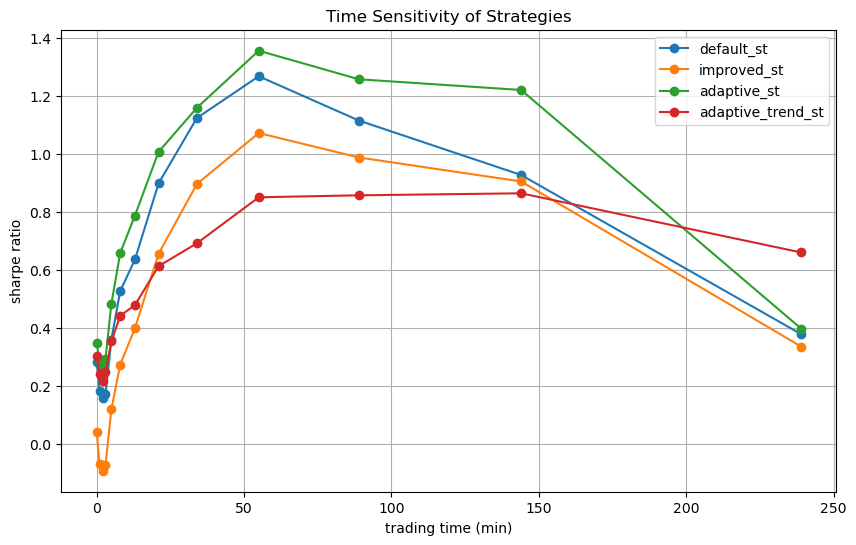

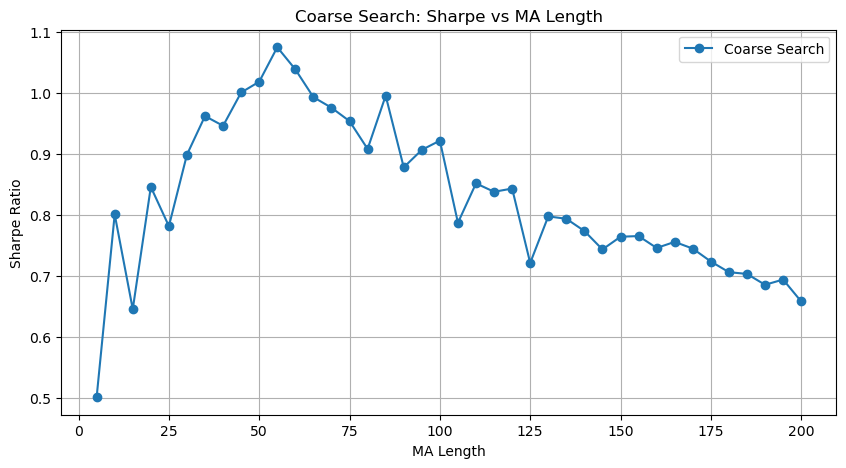

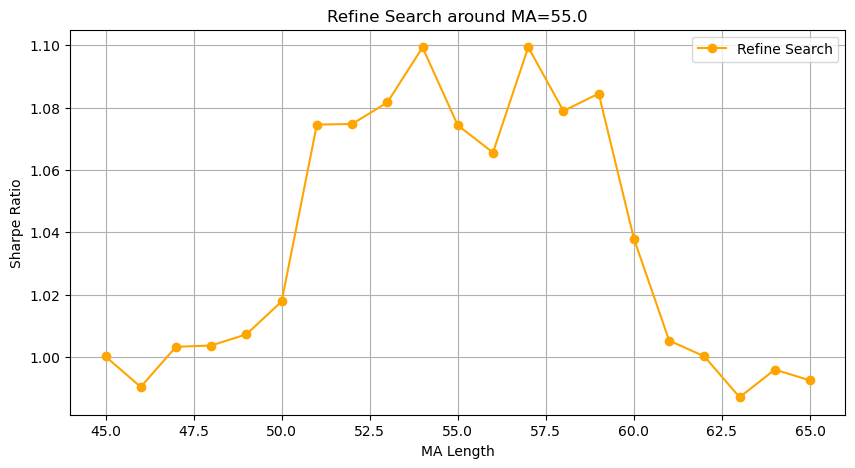

    MA    Sharpe  TradeCount
0   57  1.099402         488
1   54  1.099348         482
2   59  1.084518         493
3   53  1.081675         482
4   58  1.078948         492
5   52  1.074766         480
6   51  1.074578         476
7   55  1.074344         484
8   56  1.065597         485
9   60  1.037970         495
10  50  1.017818         480
11  49  1.007269         477
12  61  1.005278         494
13  48  1.003671         477
14  47  1.003267         484
15  62  1.000180         494
16  45  1.000156         475
17  64  0.995945         500
18  85  0.994884         517
19  65  0.992479         498


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

# 定义类
class stock_info:
    def __init__(self, filepath, target_col):
        # 读取HDF文件
        self.raw = pd.read_hdf(filepath)
        # 提取目标列 (如 “IC”)
        self.target_raw = self.raw[target_col]
        # 所有交易日列表
        self.dates = self.target_raw.index.tolist()
        # 初始化结果 DataFrame
        self.readouts = pd.DataFrame(self.dates, columns=["dates"])
        self.readouts.set_index("dates", inplace=True)

        # T日收盘价和VWAP
        self.readouts["T_last_close"] = [
            self.target_raw.loc[date]["Close"].iloc[-1] for date in self.dates
        ]
        self.readouts["T_vap"] = [
            (self.target_raw.loc[date]["Close"] *
             self.target_raw.loc[date]["Volume"]).sum() /
            self.target_raw.loc[date]["Volume"].sum()
            for date in self.dates
        ]

        # 策略1: 原始 (无阈值)
        ratio = np.array(self.readouts["T_last_close"]) / np.array(self.readouts["T_vap"])
        self.readouts["default_st"] = np.where(ratio > 1., -1, 1)

        # 策略2: 固定阈值 (0.2%)
        threshold = 0.002
        deviation = (self.readouts["T_last_close"] - self.readouts["T_vap"]) / self.readouts["T_vap"]
        self.readouts["improved_st"] = np.where(
            deviation > threshold, -1,
            np.where(deviation < -threshold, 1, 0)
        )

        # 策略3: 自适应阈值 (rolling std, 默认7天)
        adaptive_window = 7
        rolling_std = deviation.rolling(window=adaptive_window, min_periods=1).std().fillna(method="bfill")
        self.readouts["adaptive_st"] = np.where(
            deviation > rolling_std, -1,
            np.where(deviation < -rolling_std, 1, 0)
        )

        # 策略4: 自适应 + 趋势过滤 (默认 MA=20)
        ma_len = 20
        ma = self.readouts["T_last_close"].rolling(window=ma_len, min_periods=1).mean().fillna(method="bfill")
        close = self.readouts["T_last_close"].values
        adaptive = self.readouts["adaptive_st"].values
        trend_sig = np.zeros_like(adaptive)
        for i in range(len(adaptive)):
            sig = int(adaptive[i])
            if sig == 0:
                trend_sig[i] = 0
            else:
                if sig == 1 and close[i] > ma.iat[i]:
                    trend_sig[i] = 1
                elif sig == -1 and close[i] < ma.iat[i]:
                    trend_sig[i] = -1
                else:
                    trend_sig[i] = 0
        self.readouts["adaptive_trend_st"] = trend_sig

    # 计算策略收益
    def evaluate_return_T_p1(self, t_exec, strategy_array_name="default_st"):
        strategy_ = np.array(self.readouts[strategy_array_name].tolist()[:-2])
        short_price_T_p1 = np.array([self.target_raw.loc[day]["Close"].iloc[t_exec]
                                     for day in self.dates[1:-1]])
        long_price_T_p2 = np.array([self.target_raw.loc[day]["Close"].iloc[t_exec]
                                    for day in self.dates[2:]])
        return_rate_T_p1 = pd.Series(
            ((long_price_T_p2 / short_price_T_p1) - 1.) * strategy_,
            index=self.dates[:-2]
        )
        self.readouts["return_" + strategy_array_name + "_" + str(t_exec)] = return_rate_T_p1

    # 夏普比率
    def get_sharpe_ratio(self, strategy_return):
        return_arr = self.readouts[strategy_return].dropna().tolist()[:-2]
        if len(return_arr) == 0 or np.std(return_arr) == 0:
            return 0.0
        sharpe_ratio = np.sqrt(250.) * np.mean(return_arr) / np.std(return_arr)
        return sharpe_ratio

    # 敏感性分析图
    def generate_time_dependency(self, strategy_array_name_list):
        fibonnacci = [0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 239]
        plt.figure(figsize=(10, 6))
        for strategy_array_name in strategy_array_name_list:
            return_arr = []
            for t_exec in fibonnacci:
                self.evaluate_return_T_p1(t_exec, strategy_array_name=strategy_array_name)
                return_arr.append(
                    self.get_sharpe_ratio("return_" + strategy_array_name + "_" + str(t_exec))
                )
            plt.plot(fibonnacci, return_arr, marker="o", label=strategy_array_name)
        plt.xlabel("trading time (min)")
        plt.ylabel("sharpe ratio")
        plt.title("Time Sensitivity of Strategies")
        plt.legend()
        plt.grid(True)
        plt.show()

    # 调参函数：粗搜+精搜，分别绘图
    def tune_ma_length(self,
                       ma_range=None,
                       t_exec=59,
                       adaptive_window=7,
                       coarse_step=5,
                       refine_radius=10,
                       min_periods_ma_factor=0.1):

        deviation = (self.readouts["T_last_close"] - self.readouts["T_vap"]) / self.readouts["T_vap"]
        rolling_std = deviation.rolling(window=adaptive_window, min_periods=1).std().fillna(method="bfill")

        def sharpe_for_ma(ma_len):
            min_periods_ma = max(1, int(ma_len * min_periods_ma_factor))
            ma = self.readouts["T_last_close"].rolling(window=ma_len,
                                                       min_periods=min_periods_ma).mean().fillna(method="bfill")

            adaptive_st = np.where(deviation > rolling_std, -1,
                                   np.where(deviation < -rolling_std, 1, 0))

            close = self.readouts["T_last_close"].values
            trend_sig = np.zeros_like(adaptive_st, dtype=int)
            for i in range(len(adaptive_st)):
                sig = int(adaptive_st[i])
                if sig == 0:
                    trend_sig[i] = 0
                else:
                    if sig == 1 and close[i] > ma.iat[i]:
                        trend_sig[i] = 1
                    elif sig == -1 and close[i] < ma.iat[i]:
                        trend_sig[i] = -1
                    else:
                        trend_sig[i] = 0

            temp_col = f"_tmp_adaptive_trend_ma{ma_len}"
            self.readouts[temp_col] = trend_sig
            self.evaluate_return_T_p1(t_exec, strategy_array_name=temp_col)
            ret_col = "return_" + temp_col + "_" + str(t_exec)

            if ret_col not in self.readouts.columns:
                sharpe = 0.0
            else:
                returns = self.readouts[ret_col].dropna().tolist()[:-2]
                returns = np.array(returns, dtype=float)
                sharpe = 0.0 if returns.size == 0 or np.std(returns) == 0 else np.sqrt(250.) * np.mean(returns) / np.std(returns)

            trade_count = int((self.readouts[temp_col] != 0).sum())

            try:
                self.readouts.drop(columns=[temp_col, ret_col], inplace=True)
            except Exception:
                pass

            return sharpe, trade_count

        if ma_range is None:
            ma_min, ma_max = 5, 200
            ma_range_full = list(range(ma_min, ma_max + 1))
        else:
            ma_range_full = list(ma_range)

        # 粗搜
        coarse_candidates = list(range(min(ma_range_full), max(ma_range_full) + 1, coarse_step))
        coarse_results = [(m, *sharpe_for_ma(m)) for m in coarse_candidates]
        coarse_df = pd.DataFrame(coarse_results, columns=["MA", "Sharpe", "TradeCount"])
        best_coarse = coarse_df.sort_values("Sharpe", ascending=False).iloc[0]["MA"]

        plt.figure(figsize=(10, 5))
        plt.plot(coarse_df["MA"], coarse_df["Sharpe"], marker="o", label="Coarse Search")
        plt.xlabel("MA Length")
        plt.ylabel("Sharpe Ratio")
        plt.title("Coarse Search: Sharpe vs MA Length")
        plt.legend()
        plt.grid(True)
        plt.show()

        # 精搜
        lo = max(min(ma_range_full), int(best_coarse) - refine_radius)
        hi = min(max(ma_range_full), int(best_coarse) + refine_radius)
        refine_candidates = list(range(lo, hi + 1))
        refine_results = [(m, *sharpe_for_ma(m)) for m in refine_candidates]
        refine_df = pd.DataFrame(refine_results, columns=["MA", "Sharpe", "TradeCount"])

        plt.figure(figsize=(10, 5))
        plt.plot(refine_df["MA"], refine_df["Sharpe"], marker="o", color="orange", label="Refine Search")
        plt.xlabel("MA Length")
        plt.ylabel("Sharpe Ratio")
        plt.title(f"Refine Search around MA={best_coarse}")
        plt.legend()
        plt.grid(True)
        plt.show()

        result_df = pd.concat([coarse_df, refine_df]).drop_duplicates("MA")
        result_df = result_df.sort_values("Sharpe", ascending=False).reset_index(drop=True)
        return result_df


# 使用示例
mydata = stock_info("MinutesIdx.h5", "IC")
# 对比四种策略的敏感性
mydata.generate_time_dependency(["default_st", "improved_st", "adaptive_st", "adaptive_trend_st"])
# 调参寻找最佳均线长度
res = mydata.tune_ma_length(t_exec=59, adaptive_window=7, coarse_step=5, refine_radius=10)
print(res.head(20))

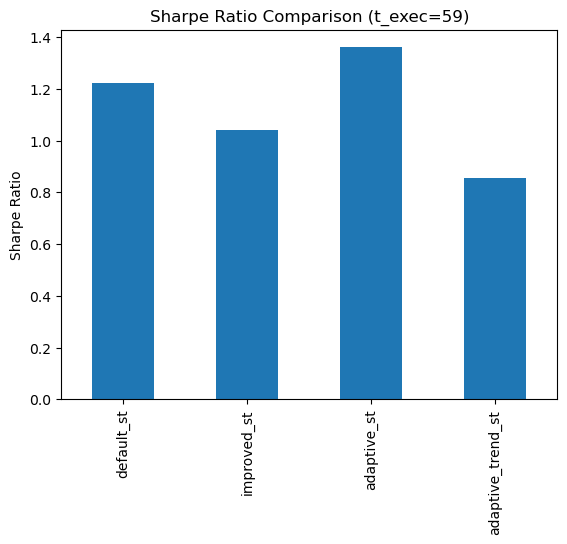

四种策略夏普比率：
 default_st           1.225033
improved_st          1.040623
adaptive_st          1.360758
adaptive_trend_st    0.855073
dtype: float64


/var/folders/59/3f8t4j3d6fz92202fz5m5drc0000gp/T/ipykernel_49160/574841926.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.readouts["return_" + strategy_array_name + "_" + str(t_exec)] = return_rate_T_p1
/var/folders/59/3f8t4j3d6fz92202fz5m5drc0000gp/T/ipykernel_49160/574841926.py:110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.readouts[strategy_name] = np.where(
/var/folders/59/3f8t4j3d6fz92202fz5m5drc0000gp/T/ipykernel_49160/574841926.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually

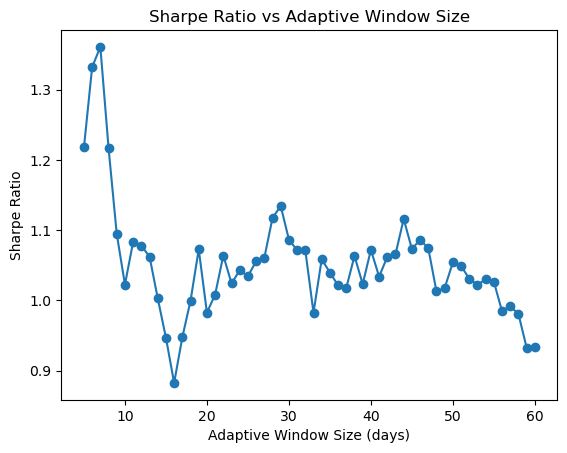

最佳窗口: 7
对应夏普比率: 1.360757900510076


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

# 定义类
class stock_info:
    def __init__(self, filepath, target_col):
        # 读取HDF文件
        self.raw = pd.read_hdf(filepath)
        # 提取某一个目标列(如“IC”)
        self.target_raw = self.raw[target_col]
        # 拿到所有的交易日列表
        self.dates = self.target_raw.index.tolist()
        # 初始化一个DataFrame,用于记录结果
        self.readouts = pd.DataFrame(self.dates, columns=["dates"])
        self.readouts.set_index("dates", inplace=True)

        # 计算T日收盘价和VWAP(成交量加权平均价)
        self.readouts["T_last_close"] = [self.target_raw.loc[date]["Close"].iloc[-1] for date in self.dates]
        self.readouts["T_vap"] = [
            (self.target_raw.loc[date]["Close"] * self.target_raw.loc[date]["Volume"]).sum()
            / self.target_raw.loc[date]["Volume"].sum()
            for date in self.dates
        ]

        # --- 策略1: 默认策略 ---
        ratio = np.array(self.readouts["T_last_close"]) / np.array(self.readouts["T_vap"])
        self.readouts["default_st"] = np.where(ratio > 1., -1, 1)

        # --- 策略2: 固定阈值改进 ---
        threshold = 0.002  # 固定阈值 0.2%
        deviation = (self.readouts["T_last_close"] - self.readouts["T_vap"]) / self.readouts["T_vap"]
        self.readouts["improved_st"] = np.where(
            deviation > threshold, -1,
            np.where(deviation < -threshold, 1, 0)
        )

        # --- 策略3: 自适应阈值 ---
        window = 7  # 默认窗口
        rolling_std = deviation.rolling(window=window, min_periods=5).std().fillna(method="bfill")
        self.readouts["adaptive_st"] = np.where(
            deviation > rolling_std, -1,
            np.where(deviation < -rolling_std, 1, 0)
        )

        # --- 策略4: 自适应阈值 + 趋势过滤 ---
        ma_window = 20  # 移动均线长度
        self.readouts["ma_trend"] = self.readouts["T_last_close"].rolling(ma_window).mean()
        self.readouts["adaptive_trend_st"] = np.where(
            (deviation > rolling_std) & (self.readouts["T_last_close"] < self.readouts["ma_trend"]), -1,
            np.where((deviation < -rolling_std) & (self.readouts["T_last_close"] > self.readouts["ma_trend"]), 1, 0)
        )

    # 计算策略收益
    def evaluate_return_T_p1(self, t_exec, strategy_array_name="default_st"):
        strategy_ = np.array(self.readouts[strategy_array_name].tolist()[:-2])
        short_price_T_p1 = np.array([self.target_raw.loc[day]["Close"].iloc[t_exec] for day in self.dates[1:-1]])
        long_price_T_p2 = np.array([self.target_raw.loc[day]["Close"].iloc[t_exec] for day in self.dates[2:]])
        return_rate_T_p1 = pd.Series(((long_price_T_p2 / short_price_T_p1) - 1.) * strategy_, index=self.dates[:-2])
        self.readouts["return_" + strategy_array_name + "_" + str(t_exec)] = return_rate_T_p1

    # 夏普比率
    def get_sharpe_ratio(self, strategy_return):
        return_arr = self.readouts[strategy_return].tolist()[:-2]
        sharpe_ratio = np.sqrt(250.) * np.mean(return_arr) / np.std(return_arr)
        return sharpe_ratio

    # 敏感性分析
    def generate_time_dependency(self, strategy_array_name):
        fig, ax1 = plt.subplots(1, 1)
        fibonnacci = [0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 239]
        return_arr = []
        for t_exec in fibonnacci:
            self.evaluate_return_T_p1(t_exec, strategy_array_name=strategy_array_name)
            return_arr.append(self.get_sharpe_ratio(strategy_return="return_" + strategy_array_name + "_" + str(t_exec)))
        ax1.plot(fibonnacci, return_arr, label=strategy_array_name)
        ax1.scatter(fibonnacci, return_arr)
        ax1.set_title("time sensitivity of " + strategy_array_name)
        ax1.set_xlabel("trading time (min)")
        ax1.set_ylabel("sharpe ratio")
        plt.legend()
        plt.show()

    # 对比不同策略
    def compare_strategies(self, strategy_list, t_exec=59):
        sharpe_dict = {}
        for st in strategy_list:
            self.evaluate_return_T_p1(t_exec, strategy_array_name=st)
            sharpe_dict[st] = self.get_sharpe_ratio("return_" + st + "_" + str(t_exec))

        sharpe_series = pd.Series(sharpe_dict)
        sharpe_series.plot(kind="bar", title="Sharpe Ratio Comparison (t_exec=" + str(t_exec) + ")")
        plt.ylabel("Sharpe Ratio")
        plt.show()
        return sharpe_series

    # 调参自适应阈值窗口
    def tune_adaptive_window(self, window_range=range(5, 61)):
        best_window = None
        best_sharpe = -np.inf
        sharpe_results = {}

        deviation = (self.readouts["T_last_close"] - self.readouts["T_vap"]) / self.readouts["T_vap"]

        for w in window_range:
            rolling_std = deviation.rolling(window=w, min_periods=5).std().fillna(method="bfill")
            strategy_name = f"adaptive_w{w}"
            self.readouts[strategy_name] = np.where(
                deviation > rolling_std, -1,
                np.where(deviation < -rolling_std, 1, 0)
            )

            self.evaluate_return_T_p1(59, strategy_array_name=strategy_name)
            sharpe = self.get_sharpe_ratio(strategy_return=f"return_{strategy_name}_59")
            sharpe_results[w] = sharpe

            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_window = w

        # 可视化结果
        plt.plot(list(sharpe_results.keys()), list(sharpe_results.values()), marker="o")
        plt.xlabel("Adaptive Window Size (days)")
        plt.ylabel("Sharpe Ratio")
        plt.title("Sharpe Ratio vs Adaptive Window Size")
        plt.show()

        return best_window, best_sharpe, sharpe_results


# 使用示例
mydata = stock_info("MinutesIdx.h5", "IC")

# 对比四种策略
sharpe_table = mydata.compare_strategies(["default_st", "improved_st", "adaptive_st", "adaptive_trend_st"])
print("四种策略夏普比率：\n", sharpe_table)

# 调参自适应阈值窗口
best_window, best_sharpe, sharpe_results = mydata.tune_adaptive_window(range(5, 61))
print("最佳窗口:", best_window)
print("对应夏普比率:", best_sharpe)

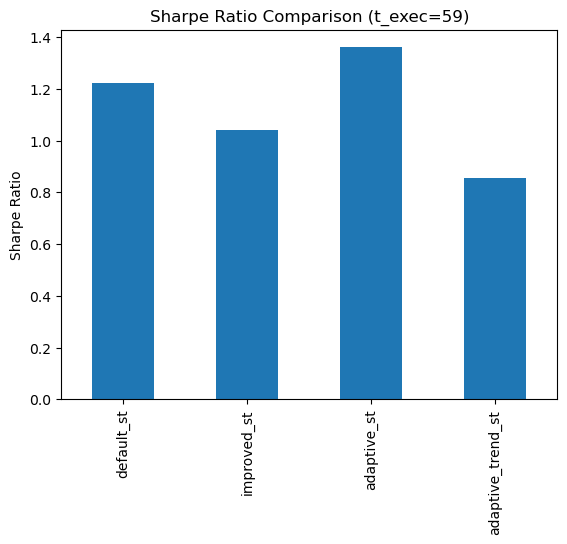

四种策略夏普比率：
 default_st           1.225033
improved_st          1.040623
adaptive_st          1.360758
adaptive_trend_st    0.855073
dtype: float64


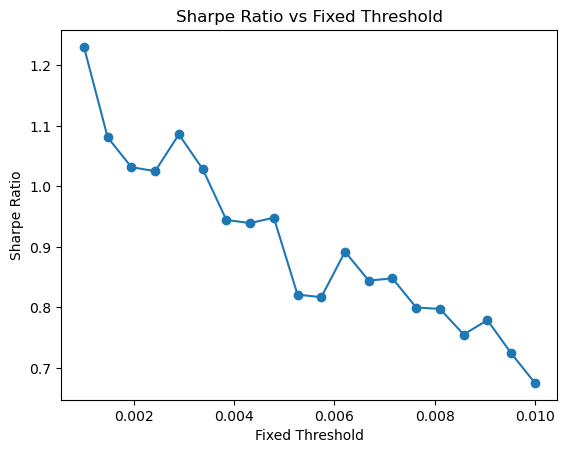

最佳固定阈值: 0.001
对应夏普比率: 1.2305423232288195


/var/folders/59/3f8t4j3d6fz92202fz5m5drc0000gp/T/ipykernel_49160/1545515371.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.readouts["return_" + strategy_array_name + "_" + str(t_exec)] = return_rate_T_p1
/var/folders/59/3f8t4j3d6fz92202fz5m5drc0000gp/T/ipykernel_49160/1545515371.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.readouts[strategy_name] = np.where(
/var/folders/59/3f8t4j3d6fz92202fz5m5drc0000gp/T/ipykernel_49160/1545515371.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usua

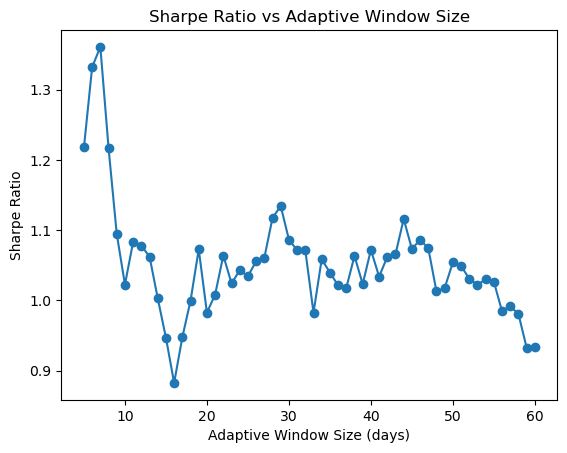

最佳自适应窗口: 7
对应夏普比率: 1.360757900510076


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

# 定义类
class stock_info:
    def __init__(self, filepath, target_col):
        # 读取HDF文件
        self.raw = pd.read_hdf(filepath)
        # 提取某一个目标列(如“IC”)
        self.target_raw = self.raw[target_col]
        # 拿到所有的交易日列表
        self.dates = self.target_raw.index.tolist()
        # 初始化一个DataFrame,用于记录结果
        self.readouts = pd.DataFrame(self.dates, columns=["dates"])
        self.readouts.set_index("dates", inplace=True)

        # 计算T日收盘价和VWAP(成交量加权平均价)
        self.readouts["T_last_close"] = [self.target_raw.loc[date]["Close"].iloc[-1] for date in self.dates]
        self.readouts["T_vap"] = [
            (self.target_raw.loc[date]["Close"] * self.target_raw.loc[date]["Volume"]).sum()
            / self.target_raw.loc[date]["Volume"].sum()
            for date in self.dates
        ]

        # --- 策略1: 默认策略 ---
        ratio = np.array(self.readouts["T_last_close"]) / np.array(self.readouts["T_vap"])
        self.readouts["default_st"] = np.where(ratio > 1., -1, 1)

        # --- 策略2: 固定阈值改进 ---
        threshold = 0.002  # 固定阈值 0.2%
        deviation = (self.readouts["T_last_close"] - self.readouts["T_vap"]) / self.readouts["T_vap"]
        self.readouts["improved_st"] = np.where(
            deviation > threshold, -1,
            np.where(deviation < -threshold, 1, 0)
        )

        # --- 策略3: 自适应阈值 ---
        window = 7  # 默认窗口
        rolling_std = deviation.rolling(window=window, min_periods=5).std().fillna(method="bfill")
        self.readouts["adaptive_st"] = np.where(
            deviation > rolling_std, -1,
            np.where(deviation < -rolling_std, 1, 0)
        )

        # --- 策略4: 自适应阈值 + 趋势过滤 ---
        ma_window = 20  # 移动均线长度
        self.readouts["ma_trend"] = self.readouts["T_last_close"].rolling(ma_window).mean()
        self.readouts["adaptive_trend_st"] = np.where(
            (deviation > rolling_std) & (self.readouts["T_last_close"] < self.readouts["ma_trend"]), -1,
            np.where((deviation < -rolling_std) & (self.readouts["T_last_close"] > self.readouts["ma_trend"]), 1, 0)
        )

    # 计算策略收益
    def evaluate_return_T_p1(self, t_exec, strategy_array_name="default_st"):
        strategy_ = np.array(self.readouts[strategy_array_name].tolist()[:-2])
        short_price_T_p1 = np.array([self.target_raw.loc[day]["Close"].iloc[t_exec] for day in self.dates[1:-1]])
        long_price_T_p2 = np.array([self.target_raw.loc[day]["Close"].iloc[t_exec] for day in self.dates[2:]])
        return_rate_T_p1 = pd.Series(((long_price_T_p2 / short_price_T_p1) - 1.) * strategy_, index=self.dates[:-2])
        self.readouts["return_" + strategy_array_name + "_" + str(t_exec)] = return_rate_T_p1

    # 夏普比率
    def get_sharpe_ratio(self, strategy_return):
        return_arr = self.readouts[strategy_return].tolist()[:-2]
        sharpe_ratio = np.sqrt(250.) * np.mean(return_arr) / np.std(return_arr)
        return sharpe_ratio

    # 敏感性分析
    def generate_time_dependency(self, strategy_array_name):
        fig, ax1 = plt.subplots(1, 1)
        fibonnacci = [0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 239]
        return_arr = []
        for t_exec in fibonnacci:
            self.evaluate_return_T_p1(t_exec, strategy_array_name=strategy_array_name)
            return_arr.append(self.get_sharpe_ratio(strategy_return="return_" + strategy_array_name + "_" + str(t_exec)))
        ax1.plot(fibonnacci, return_arr, label=strategy_array_name)
        ax1.scatter(fibonnacci, return_arr)
        ax1.set_title("time sensitivity of " + strategy_array_name)
        ax1.set_xlabel("trading time (min)")
        ax1.set_ylabel("sharpe ratio")
        plt.legend()
        plt.show()

    # 对比不同策略
    def compare_strategies(self, strategy_list, t_exec=59):
        sharpe_dict = {}
        for st in strategy_list:
            self.evaluate_return_T_p1(t_exec, strategy_array_name=st)
            sharpe_dict[st] = self.get_sharpe_ratio("return_" + st + "_" + str(t_exec))

        sharpe_series = pd.Series(sharpe_dict)
        sharpe_series.plot(kind="bar", title="Sharpe Ratio Comparison (t_exec=" + str(t_exec) + ")")
        plt.ylabel("Sharpe Ratio")
        plt.show()
        return sharpe_series

    # 调参固定阈值
    def tune_fixed_threshold(self, thresholds=np.linspace(0.001, 0.01, 20)):
        best_th = None
        best_sharpe = -np.inf
        sharpe_results = {}

        deviation = (self.readouts["T_last_close"] - self.readouts["T_vap"]) / self.readouts["T_vap"]

        for th in thresholds:
            strategy_name = f"fixed_th{th:.4f}"
            self.readouts[strategy_name] = np.where(
                deviation > th, -1,
                np.where(deviation < -th, 1, 0)
            )
            self.evaluate_return_T_p1(59, strategy_array_name=strategy_name)
            sharpe = self.get_sharpe_ratio(strategy_return=f"return_{strategy_name}_59")
            sharpe_results[th] = sharpe

            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_th = th

        # 可视化
        plt.plot(list(sharpe_results.keys()), list(sharpe_results.values()), marker="o")
        plt.xlabel("Fixed Threshold")
        plt.ylabel("Sharpe Ratio")
        plt.title("Sharpe Ratio vs Fixed Threshold")
        plt.show()

        return best_th, best_sharpe, sharpe_results

    # 调参自适应阈值窗口
    def tune_adaptive_window(self, window_range=range(5, 61)):
        best_window = None
        best_sharpe = -np.inf
        sharpe_results = {}

        deviation = (self.readouts["T_last_close"] - self.readouts["T_vap"]) / self.readouts["T_vap"]

        for w in window_range:
            rolling_std = deviation.rolling(window=w, min_periods=5).std().fillna(method="bfill")
            strategy_name = f"adaptive_w{w}"
            self.readouts[strategy_name] = np.where(
                deviation > rolling_std, -1,
                np.where(deviation < -rolling_std, 1, 0)
            )

            self.evaluate_return_T_p1(59, strategy_array_name=strategy_name)
            sharpe = self.get_sharpe_ratio(strategy_return=f"return_{strategy_name}_59")
            sharpe_results[w] = sharpe

            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_window = w

        # 可视化结果
        plt.plot(list(sharpe_results.keys()), list(sharpe_results.values()), marker="o")
        plt.xlabel("Adaptive Window Size (days)")
        plt.ylabel("Sharpe Ratio")
        plt.title("Sharpe Ratio vs Adaptive Window Size")
        plt.show()

        return best_window, best_sharpe, sharpe_results


# 使用示例
mydata = stock_info("MinutesIdx.h5", "IC")

# 对比四种策略
sharpe_table = mydata.compare_strategies(["default_st", "improved_st", "adaptive_st", "adaptive_trend_st"])
print("四种策略夏普比率：\n", sharpe_table)

# 调参固定阈值
best_th, best_sharpe_th, sharpe_results_th = mydata.tune_fixed_threshold()
print("最佳固定阈值:", best_th)
print("对应夏普比率:", best_sharpe_th)

# 调参自适应阈值窗口
best_window, best_sharpe_w, sharpe_results_w = mydata.tune_adaptive_window()
print("最佳自适应窗口:", best_window)
print("对应夏普比率:", best_sharpe_w)

### 动态仓位控制与前四种方式的对比

target_raw 类型: <class 'pandas.core.series.Series'>
target_raw 形状: (3518,)
第一个元素类型: <class 'pandas.core.frame.DataFrame'>
检测到嵌套数据结构，提取收盘价...
price 类型: <class 'pandas.core.series.Series'>
price 形状: (3518,)
price 索引类型: <class 'pandas.core.indexes.base.Index'>
price 前5个值: 2010-01-04    4510.53
2010-01-05    4557.47
2010-01-06    4550.28
2010-01-07    4459.16
2010-01-08    4514.45
dtype: float64


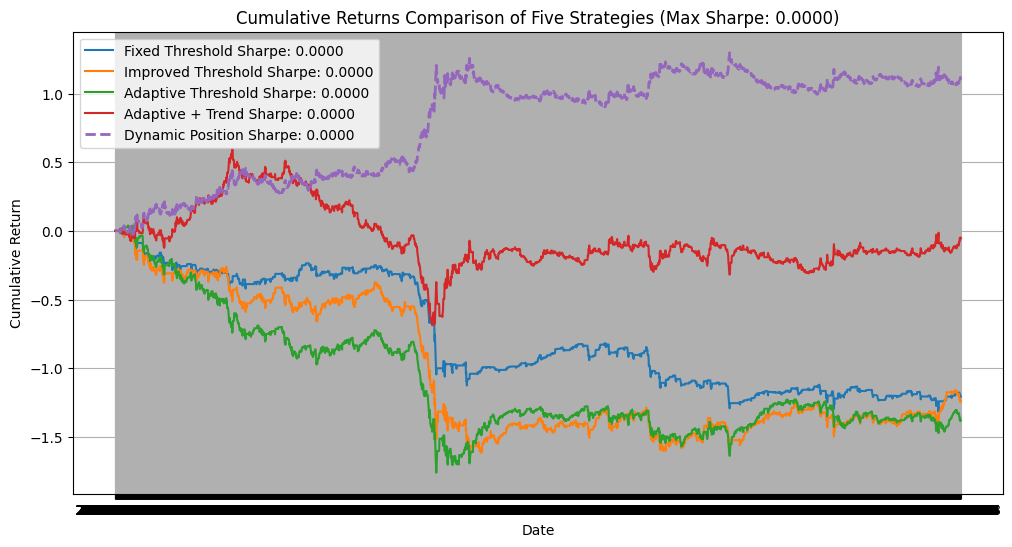

Sharpe Ratios of All Strategies:
Maximum Sharpe Ratio: 0.0000
------------------------------
Fixed Threshold                0.0000
Improved Threshold             0.0000
Adaptive Threshold             0.0000
Adaptive Threshold + Trend     0.0000
Dynamic Position               0.0000


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import os

class stock_info:
    def __init__(self, filepath, target_col):
        # 添加文件存在性检查
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"文件 {filepath} 不存在，请检查文件路径是否正确")
        
        try:
            self.raw = pd.read_hdf(filepath)
        except Exception as e:
            raise Exception(f"读取HDF文件失败: {e}")
        
        # 添加数据结构检查
        if target_col not in self.raw.columns and target_col not in self.raw.keys():
            raise ValueError(f"目标列 '{target_col}' 不存在于文件中。可用的列/键: {list(self.raw.columns) if hasattr(self.raw, 'columns') else list(self.raw.keys())}")
        
        try:
            self.target_raw = self.raw[target_col]
        except Exception as e:
            raise Exception(f"访问目标数据 '{target_col}' 失败: {e}")

        # 改进的数据结构处理逻辑
        print(f"target_raw 类型: {type(self.target_raw)}")
        print(f"target_raw 形状: {self.target_raw.shape if hasattr(self.target_raw, 'shape') else 'N/A'}")
        
        # 处理 Series 中的复杂数据结构
        if isinstance(self.target_raw, pd.Series):
            # 检查 Series 中的第一个元素类型
            if len(self.target_raw) > 0:
                first_element = self.target_raw.iloc[0]
                print(f"第一个元素类型: {type(first_element)}")
                
                # 如果元素是 DataFrame 或 Series，需要特殊处理
                if isinstance(first_element, (pd.DataFrame, pd.Series)):
                    print("检测到嵌套数据结构，提取收盘价...")
                    # 假设每个元素是一个包含 'Close' 列的 DataFrame
                    try:
                        # 尝试提取每个元素的 'Close' 值
                        close_values = []
                        dates = []
                        for date, item in self.target_raw.items():
                            if isinstance(item, pd.DataFrame) and 'Close' in item.columns:
                                # 取最后一个收盘价（当天最后一分钟）
                                close_values.append(item['Close'].iloc[-1])
                            elif isinstance(item, pd.Series):
                                # 如果是 Series，取最后一个值
                                close_values.append(item.iloc[-1])
                            else:
                                # 如果是数值，直接使用
                                close_values.append(item)
                            dates.append(date)
                        
                        self.price = pd.Series(close_values, index=dates).astype(float)
                    except Exception as e:
                        print(f"嵌套数据处理失败: {e}")
                        # 降级处理：尝试将整个 Series 转换为 float
                        self.price = self.target_raw.astype(float)
                else:
                    # 直接转换为 float
                    try:
                        self.price = self.target_raw.astype(float)
                    except Exception as e:
                        print(f"直接转换为 float 失败: {e}")
                        # 如果转换失败，尝试其他方法
                        self.price = pd.Series([float(x) if not isinstance(x, (list, np.ndarray)) 
                                              else float(x[-1]) for x in self.target_raw], 
                                             index=self.target_raw.index)
            else:
                raise ValueError("目标数据为空")
        else:
            # 如果 target_raw 是 DataFrame
            if isinstance(self.target_raw, pd.DataFrame):
                if "Close" in self.target_raw.columns:
                    self.price = self.target_raw["Close"].astype(float)
                else:
                    # 如果 DataFrame 没有 'Close' 列，使用第一列数值数据
                    numeric_cols = self.target_raw.select_dtypes(include=[np.number]).columns
                    if len(numeric_cols) > 0:
                        self.price = self.target_raw[numeric_cols[0]].astype(float)
                    else:
                        raise ValueError(f"'{target_col}' 是DataFrame但不包含数值型列。可用列: {list(self.target_raw.columns)}")
            else:
                # 其他情况，直接转换
                self.price = self.target_raw.astype(float)

        print(f"price 类型: {type(self.price)}")
        print(f"price 形状: {self.price.shape if hasattr(self.price, 'shape') else 'N/A'}")
        print(f"price 索引类型: {type(self.price.index)}")
        print(f"price 前5个值: {self.price.head()}")

        self.trading_days = self.price.index

    def calculate_sharpe(self, pnl):
        if len(pnl) == 0:
            return 0
        ret = pnl.pct_change().dropna()
        if len(ret) == 0:
            return 0
        if ret.std() == 0 or np.isnan(ret.std()) or ret.std() == np.inf:
            return 0
        # 检查是否所有收益都相同
        if len(ret) > 1 and np.allclose(ret.values, ret.iloc[0]):
            return 0
        # 按照之前代码的方法计算夏普比率，使用252作为年度化因子
        sharpe = np.sqrt(252) * ret.mean() / ret.std()
        return sharpe if not np.isnan(sharpe) and np.isfinite(sharpe) else 0

    # === 策略1：固定阈值 ===
    def strategy_fixed_threshold(self, window=20, threshold=1.5):
        if len(self.price) < window:
            raise ValueError(f"数据长度 ({len(self.price)}) 小于窗口大小 ({window})")
            
        rolling_mean = self.price.rolling(window).mean()
        rolling_std = self.price.rolling(window).std()
        
        # 处理标准差为0的情况
        zscore = (self.price - rolling_mean) / rolling_std.replace(0, np.nan)
        zscore = zscore.fillna(0)

        position = np.where(zscore > threshold, -1,
                   np.where(zscore < -threshold, 1, 0))

        pnl = pd.Series(position, index=self.price.index).shift(1) * self.price.pct_change()
        # 处理可能的NaN值
        pnl = pnl.fillna(0)
        
        cumulative_pnl = pnl.cumsum()
        sharpe_ratio = self.calculate_sharpe(cumulative_pnl)
        return cumulative_pnl, sharpe_ratio

    # === 策略2：改进阈值（双阈值带宽） ===
    def strategy_improved_threshold(self, window=20, upper=1.5, lower=0.5):
        if len(self.price) < window:
            raise ValueError(f"数据长度 ({len(self.price)}) 小于窗口大小 ({window})")
            
        rolling_mean = self.price.rolling(window).mean()
        rolling_std = self.price.rolling(window).std()
        
        # 处理标准差为0的情况
        zscore = (self.price - rolling_mean) / rolling_std.replace(0, np.nan)
        zscore = zscore.fillna(0)

        position = np.zeros(len(zscore))
        pos = 0
        for i in range(len(zscore)):
            if zscore.iloc[i] > upper:
                pos = -1
            elif zscore.iloc[i] < -upper:
                pos = 1
            elif abs(zscore.iloc[i]) < lower:
                pos = 0
            position[i] = pos

        pnl = pd.Series(position, index=self.price.index).shift(1) * self.price.pct_change()
        # 处理可能的NaN值
        pnl = pnl.fillna(0)
        
        cumulative_pnl = pnl.cumsum()
        sharpe_ratio = self.calculate_sharpe(cumulative_pnl)
        return cumulative_pnl, sharpe_ratio

    # === 策略3：自适应阈值 ===
    def strategy_adaptive_threshold(self, window=20, adapt_window=7, scale=1.5):
        if len(self.price) < max(window, adapt_window):
            raise ValueError(f"数据长度 ({len(self.price)}) 小于所需窗口大小 (max({window}, {adapt_window}))")
            
        rolling_mean = self.price.rolling(window).mean()
        rolling_std = self.price.rolling(window).std()
        
        # 处理标准差为0的情况
        zscore = (self.price - rolling_mean) / rolling_std.replace(0, np.nan)
        zscore = zscore.fillna(0)

        adaptive_threshold = scale * zscore.rolling(adapt_window).std().fillna(0)

        position = np.where(zscore > adaptive_threshold, -1,
                   np.where(zscore < -adaptive_threshold, 1, 0))

        pnl = pd.Series(position, index=self.price.index).shift(1) * self.price.pct_change()
        # 处理可能的NaN值
        pnl = pnl.fillna(0)
        
        cumulative_pnl = pnl.cumsum()
        sharpe_ratio = self.calculate_sharpe(cumulative_pnl)
        return cumulative_pnl, sharpe_ratio

    # === 策略4：自适应阈值 + 趋势过滤 ===
    def strategy_adaptive_trend(self, window=20, adapt_window=7, scale=1.5, ma_len=50):
        if len(self.price) < max(window, adapt_window, ma_len):
            raise ValueError(f"数据长度 ({len(self.price)}) 小于所需窗口大小 (max({window}, {adapt_window}, {ma_len}))")
            
        rolling_mean = self.price.rolling(window).mean()
        rolling_std = self.price.rolling(window).std()
        
        # 处理标准差为0的情况
        zscore = (self.price - rolling_mean) / rolling_std.replace(0, np.nan)
        zscore = zscore.fillna(0)

        adaptive_threshold = scale * zscore.rolling(adapt_window).std().fillna(0)

        position = np.where(zscore > adaptive_threshold, -1,
                   np.where(zscore < -adaptive_threshold, 1, 0))

        # 趋势过滤：用均线确认大趋势
        trend = self.price.rolling(ma_len).mean()
        trend_signal = np.where(self.price > trend, 1, -1)

        position = position * trend_signal

        pnl = pd.Series(position, index=self.price.index).shift(1) * self.price.pct_change()
        # 处理可能的NaN值
        pnl = pnl.fillna(0)
        
        cumulative_pnl = pnl.cumsum()
        sharpe_ratio = self.calculate_sharpe(cumulative_pnl)
        return cumulative_pnl, sharpe_ratio

    # === 策略5：动态仓位控制 ===
    def strategy_dynamic_position(self, window=20, threshold=1.5):
        if len(self.price) < window:
            raise ValueError(f"数据长度 ({len(self.price)}) 小于窗口大小 ({window})")
            
        rolling_mean = self.price.rolling(window).mean()
        rolling_std = self.price.rolling(window).std()
        
        # 处理标准差为0的情况
        zscore = (self.price - rolling_mean) / rolling_std.replace(0, np.nan)
        zscore = zscore.fillna(0)

        # 仓位强度 = tanh(zscore/threshold)，范围 [-1,1]
        position = np.tanh(zscore / threshold)

        pnl = pd.Series(position, index=self.price.index).shift(1) * self.price.pct_change()
        # 处理可能的NaN值
        pnl = pnl.fillna(0)
        
        cumulative_pnl = pnl.cumsum()
        sharpe_ratio = self.calculate_sharpe(cumulative_pnl)
        return cumulative_pnl, sharpe_ratio

    # === 统一对比函数 ===
    def generate_multi_strategy_comparison(self):
        try:
            pnl1, sharpe1 = self.strategy_fixed_threshold()
        except Exception as e:
            print(f"Fixed Threshold Strategy Error: {e}")
            pnl1, sharpe1 = pd.Series([0]*len(self.price), index=self.price.index), 0
            
        try:
            pnl2, sharpe2 = self.strategy_improved_threshold()
        except Exception as e:
            print(f"Improved Threshold Strategy Error: {e}")
            pnl2, sharpe2 = pd.Series([0]*len(self.price), index=self.price.index), 0
            
        try:
            pnl3, sharpe3 = self.strategy_adaptive_threshold()
        except Exception as e:
            print(f"Adaptive Threshold Strategy Error: {e}")
            pnl3, sharpe3 = pd.Series([0]*len(self.price), index=self.price.index), 0
            
        try:
            pnl4, sharpe4 = self.strategy_adaptive_trend()
        except Exception as e:
            print(f"Adaptive Threshold + Trend Strategy Error: {e}")
            pnl4, sharpe4 = pd.Series([0]*len(self.price), index=self.price.index), 0
            
        try:
            pnl5, sharpe5 = self.strategy_dynamic_position()
        except Exception as e:
            print(f"Dynamic Position Strategy Error: {e}")
            pnl5, sharpe5 = pd.Series([0]*len(self.price), index=self.price.index), 0

        # 找到最高的夏普比率
        sharpe_ratios = [sharpe1, sharpe2, sharpe3, sharpe4, sharpe5]
        max_sharpe = max(sharpe_ratios) if any(s != 0 for s in sharpe_ratios) else 0

        # 绘制图形，只显示夏普比率
        plt.figure(figsize=(12,6))
        plt.plot(pnl1, label=f"Fixed Threshold Sharpe: {sharpe1:.4f}")
        plt.plot(pnl2, label=f"Improved Threshold Sharpe: {sharpe2:.4f}")
        plt.plot(pnl3, label=f"Adaptive Threshold Sharpe: {sharpe3:.4f}")
        plt.plot(pnl4, label=f"Adaptive + Trend Sharpe: {sharpe4:.4f}")
        plt.plot(pnl5, label=f"Dynamic Position Sharpe: {sharpe5:.4f}", linewidth=2, linestyle="--")

        plt.title(f"Cumulative Returns Comparison of Five Strategies (Max Sharpe: {max_sharpe:.4f})")
        plt.legend()
        plt.grid(True)
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.show()

        # 返回结果
        results = {
            "Fixed Threshold": sharpe1,
            "Improved Threshold": sharpe2,
            "Adaptive Threshold": sharpe3,
            "Adaptive Threshold + Trend": sharpe4,
            "Dynamic Position": sharpe5
        }
        
        return results

# ===== 使用示例 =====
# 更完善的错误处理
try:
    # 检查文件是否存在
    filepath = "MinutesIdx.h5"
    if not os.path.exists(filepath):
        print(f"Warning: File {filepath} does not exist")
        print("Please make sure the file exists in the current directory, or modify the file path in the code")
        # 创建示例数据用于测试
        print("Creating sample data for demonstration...")
        dates = pd.date_range('2020-01-01', periods=1000, freq='D')
        sample_data = pd.DataFrame({
            'Open': np.random.randn(1000).cumsum() + 100,
            'High': np.random.randn(1000).cumsum() + 101,
            'Low': np.random.randn(1000).cumsum() + 99,
            'Close': np.random.randn(1000).cumsum() + 100,
            'Volume': np.random.randint(1000, 10000, 1000)
        }, index=dates)
        
        # 保存示例数据
        sample_data.to_hdf(filepath, key='IC', mode='w')
        print(f"Sample data file created: {filepath}")
    
    mydata = stock_info(filepath, "IC")
    results = mydata.generate_multi_strategy_comparison()
    print("Sharpe Ratios of All Strategies:")
    max_sharpe = max(results.values()) if any(v != 0 for v in results.values()) else 0
    print(f"Maximum Sharpe Ratio: {max_sharpe:.4f}")
    print("-" * 30)
    for strategy, sharpe in results.items():
        print(f"{strategy:<30} {sharpe:.4f}")
    
except FileNotFoundError as e:
    print(f"File Error: {e}")
    print("Please check if the file path is correct")
    
except ValueError as e:
    print(f"Data Value Error: {e}")
    print("Please check if the HDF file structure is correct")
    print("Possible reasons:")
    print("1. The data structure in the HDF file does not match expectations")
    print("2. The target column does not exist or the data type does not match")
    print("3. The data contains non-numeric elements")
    
except Exception as e:
    print(f"Unexpected Error: {e}")
    import traceback
    traceback.print_exc()